In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import textwrap
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import sqlite3

In [6]:
nltk.download('stopwords')
stops = set(stopwords.words('english')).union({'economics', 'economy', 'approach', 'using', 'based', 'model', 'mr', 'new', 'year','economic'})

conn = sqlite3.connect('../EconomicsFinal.db')

df = pd.read_sql_query('SELECT * FROM EconomicsFinal', conn)

vectorizer = TfidfVectorizer(stop_words=list(stops), ngram_range=(1,3))
X = vectorizer.fit_transform(df['abstract'])

nmf = NMF(n_components=10,beta_loss="kullback-leibler",solver='mu',random_state=0,)

nmf.fit(X)

def plot_top_words(model, feature_names, n_top_words=10):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words-1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx + 1} ", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)

    fig.suptitle("NMF", fontsize=40)

    plt.subplots_adjust(top=.90, bottom=0.05, wspace=0.90, hspace=0.10)
    plt.show()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\simon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


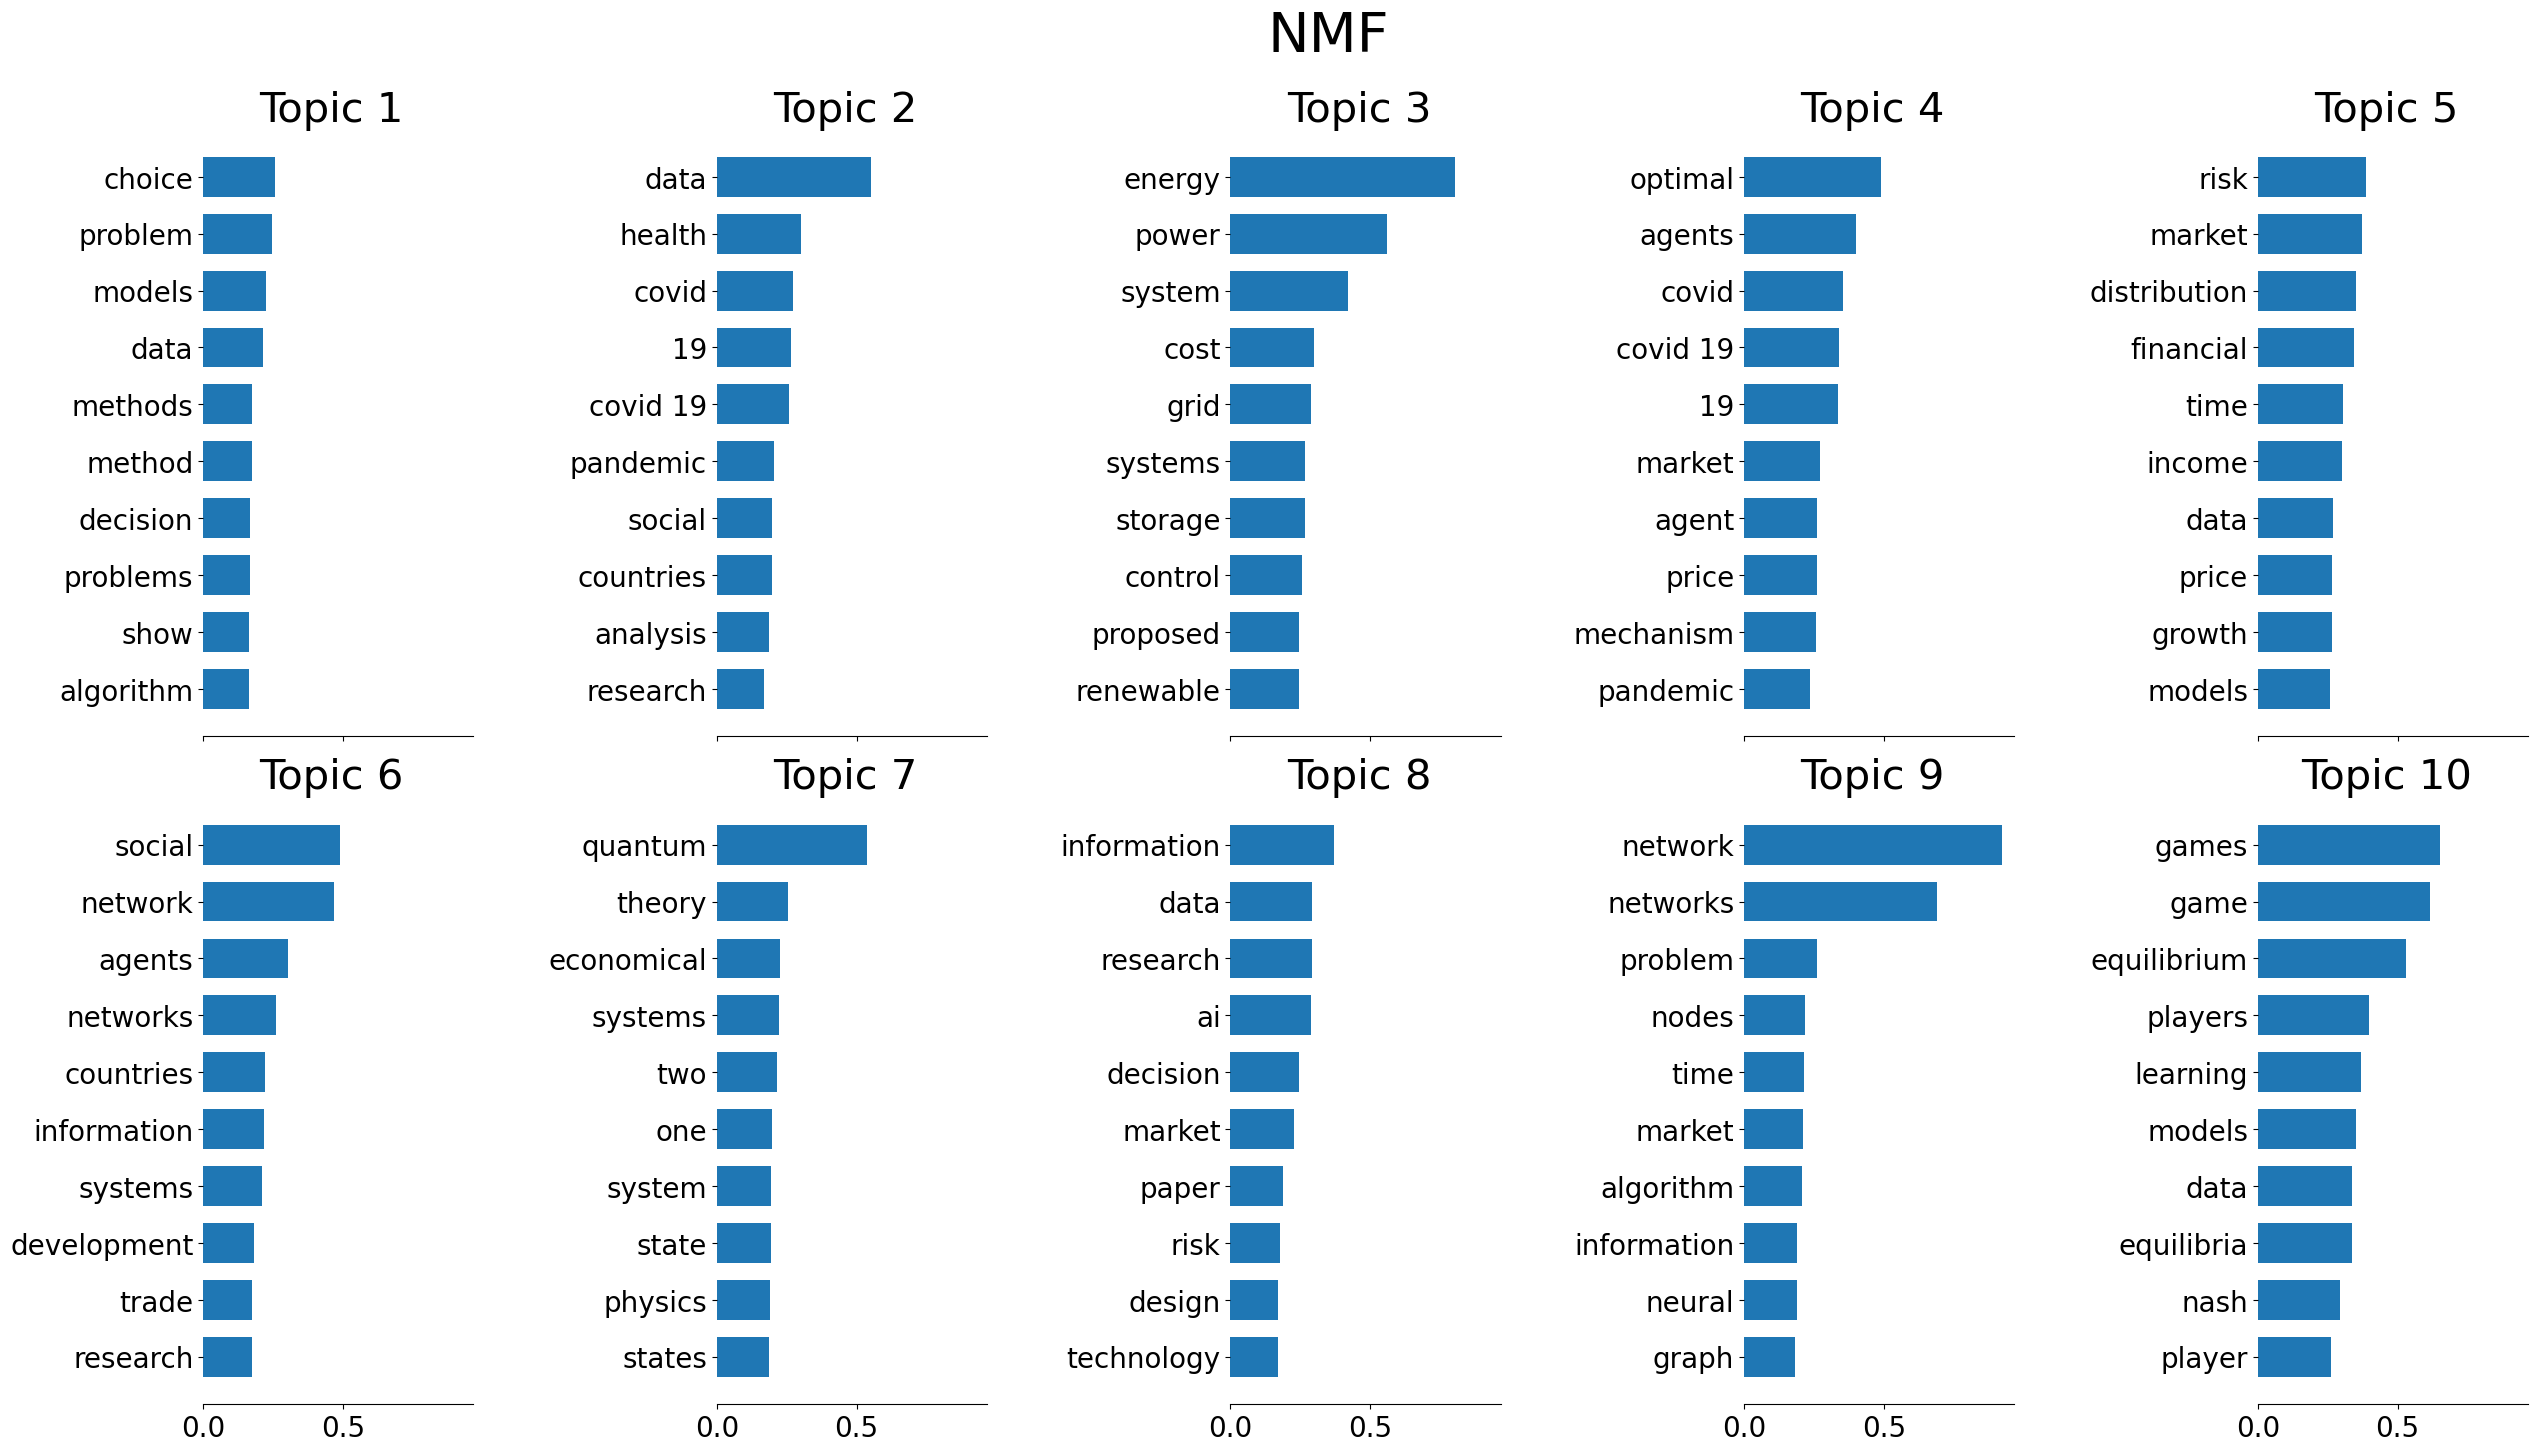

In [7]:
feature_names=vectorizer.get_feature_names_out()
plot_top_words(nmf,feature_names);

In [16]:


def plot_topic_evolution(model, feature_names, topic_idx):
    years = sorted(df['year'].unique())
    n_years = len(years)
    topic_weights = np.zeros(n_years)

    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(22, 12))
    
    for year_idx, year in enumerate(years):
        year_mask = df['year'] == year
        X_year = X[year_mask]
        topic_weights[year_idx] = model.transform(X_year)[:, topic_idx].mean()
        ax[0].scatter(year, topic_weights[year_idx], marker='x', color='blue', s=200)
        
    ax[0].plot(years, topic_weights, linewidth=2)
    ax[0].set_xlabel('Year', fontsize=16)
    ax[0].set_ylabel('Topic Weight', fontsize=16)
    ax[0].set_title(f"Topic {topic_idx+1} Evolution", fontsize=20)
    ax[0].tick_params(axis='both', labelsize=14)
    ax[0].xaxis.set_ticks(years)
    ax[0].xaxis.set_ticklabels(years, fontsize=14)
    ax[0].grid(axis='x')

    top_features_ind = model.components_[topic_idx].argsort()[:-11:-1]
    top_features = [feature_names[i] for i in top_features_ind]
    weights = model.components_[topic_idx][top_features_ind]
    ax[1].barh(top_features, weights, height=0.7)
    ax[1].tick_params(axis="both", which="major", labelsize=14)
    ax[1].set_xlabel('Top Words', fontsize=16)
    ax[1].grid(axis='x')
    
    plt.tight_layout()
    plt.show()




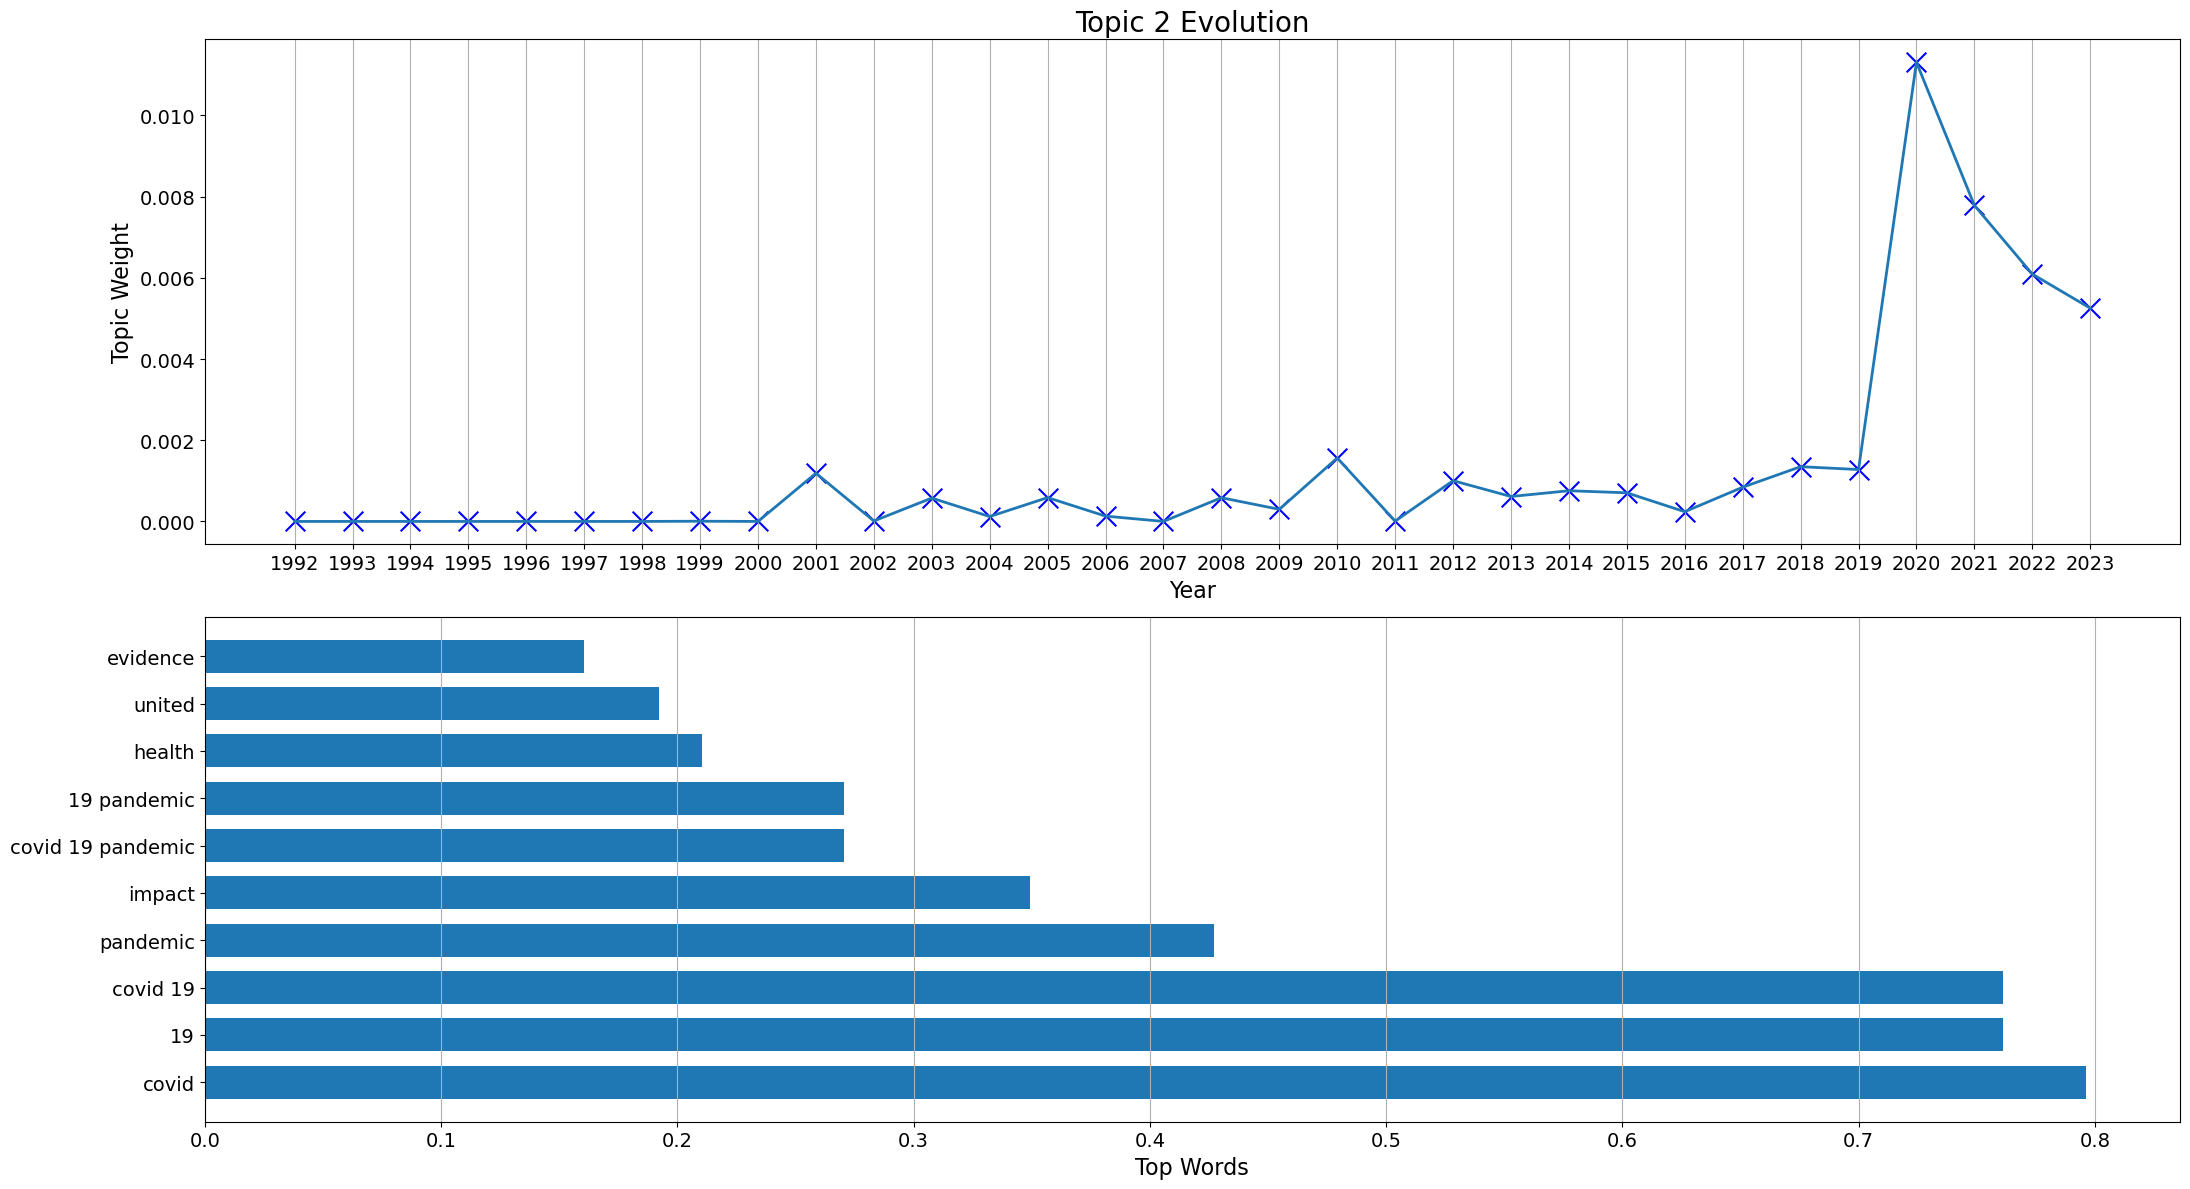

In [17]:
feature_names=vectorizer.get_feature_names_out()
plot_topic_evolution(nmf, feature_names, topic_idx=1)